In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as pt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [7]:
# Training Data
drive_url = "https://drive.google.com/file/d/1kwAOwwBgM6WE0K1l3HX_7Mk-p_hR2hiG/view?usp=sharing"

# 50% stratified training data sampling, incase of loading times
# https://drive.google.com/file/d/1CqgQgVREap5sogvERbZ8Ow35CTbv5AxD/view?usp=sharing

# Convert the Google Drive URL to a direct download URL
file_id = drive_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file into a DataFrame
train = pd.read_csv(download_url)

# Display the first few rows of the DataFrame
print(train.head())

   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1    Male  50.0             0              0          Yes   Private   
1   2  Female  52.0             0              0          Yes   Private   
2   3  Female  26.0             0              0           No  Govt_job   
3   4  Female  37.0             0              0          Yes   Private   
4   5    Male  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Rural              88.10  29.1  formerly smoked       0  
1          Rural              80.07  38.9           smokes       0  
2          Urban              89.11  23.3           smokes       0  
3          Rural              81.36  36.1     never smoked       0  
4          Rural              82.59  29.6     never smoked       1  


In [8]:
# Number of unique values in each feature
train.nunique()

,0
id,12243
gender,3
age,106
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3449
bmi,395


In [9]:
print("\nMissing Values:\n", train.isnull().sum())
print("\nData Types:\n", train.dtypes)
print("\nDuplicate Entries:", train.duplicated().sum())


Missing Values:
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Data Types:
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Duplicate Entries: 0


In [10]:
numerical_features = [
    "age", "avg_glucose_level", "bmi"
]
categorical_features = [
    "gender", "hypertension","heart_disease",
    "ever_married", "work_type","Residence_type",
    "smoking_status"
]

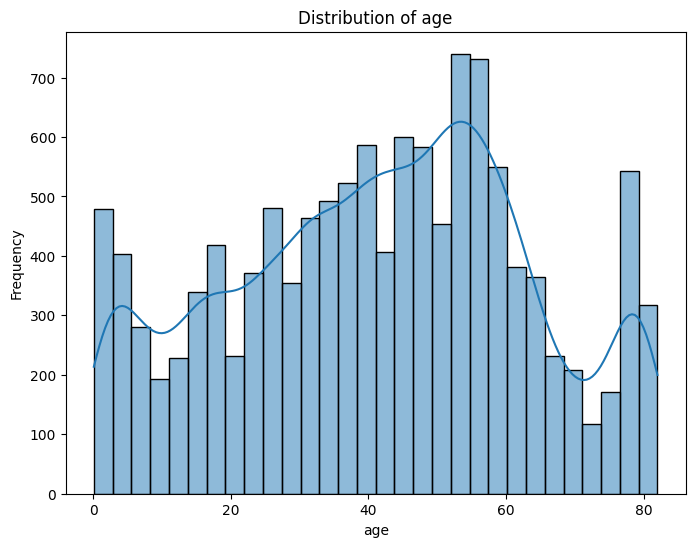

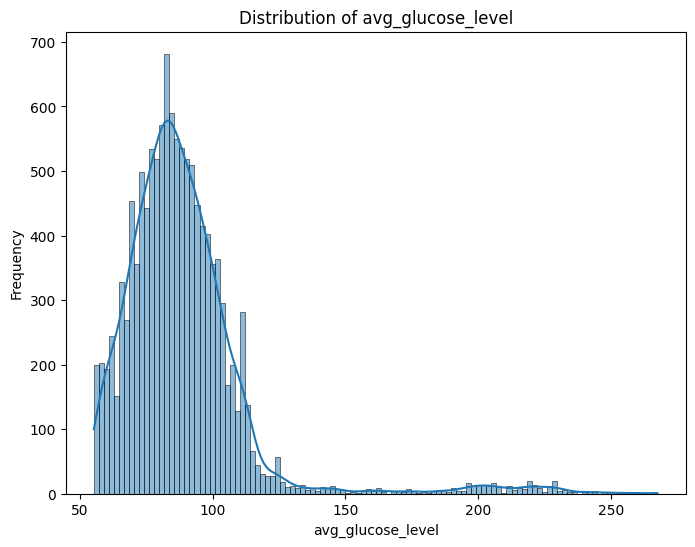

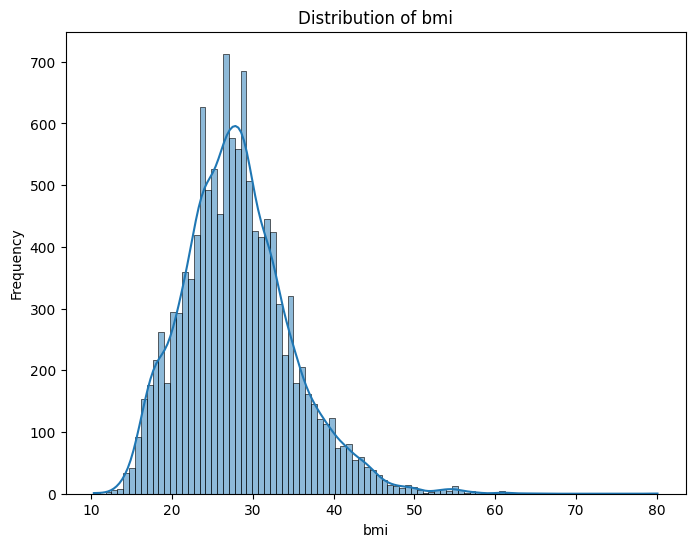

In [11]:
for col in numerical_features:
  plt.figure(figsize=(8, 6))
  sns.histplot(train[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

In [12]:
def remove_outliers_tukey(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Plot before removing outliers
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=cleaned_df[col])
        plt.title(f"Before Removing Outliers: {col}")
        plt.show()

        # Remove outliers
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

        # Plot after removing outliers
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=cleaned_df[col])
        plt.title(f"After Removing Outliers: {col}")
        plt.show()

    return cleaned_df

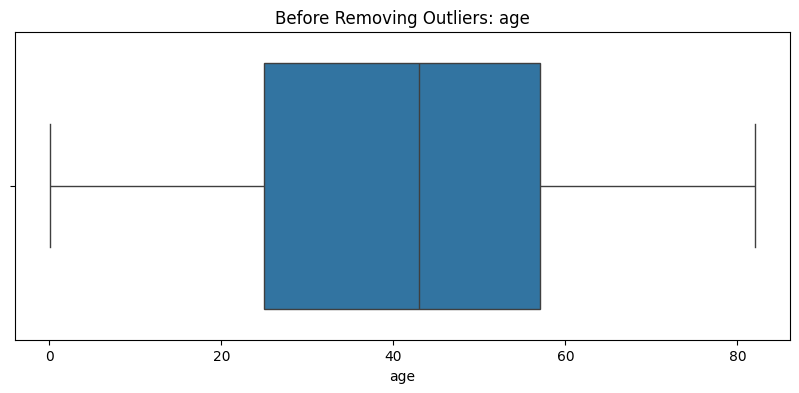

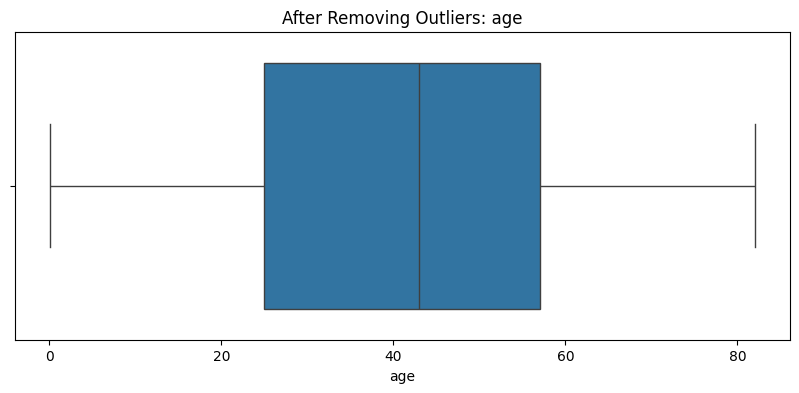

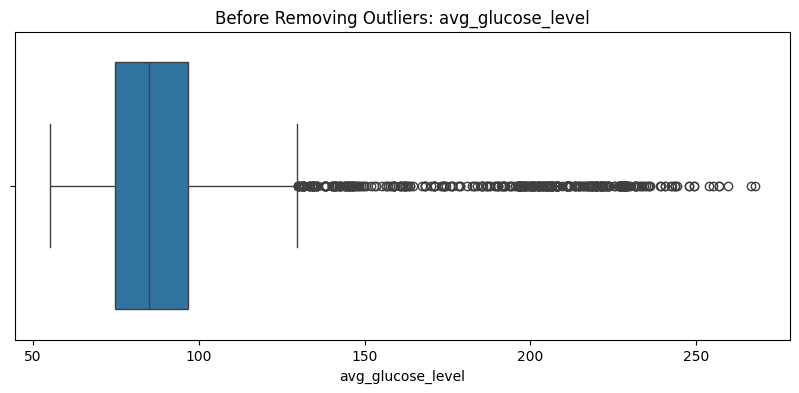

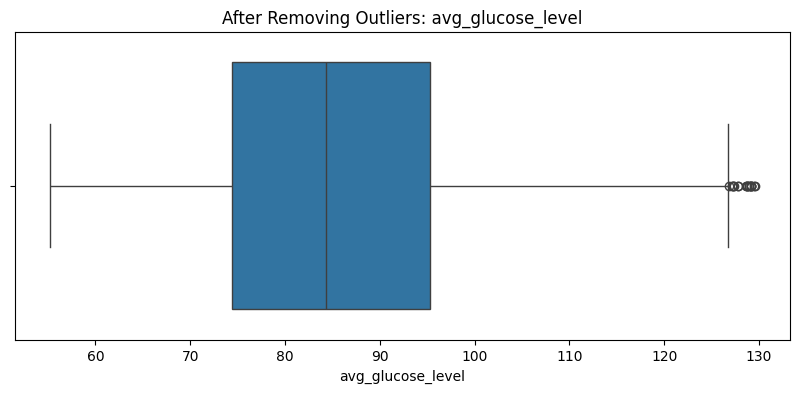

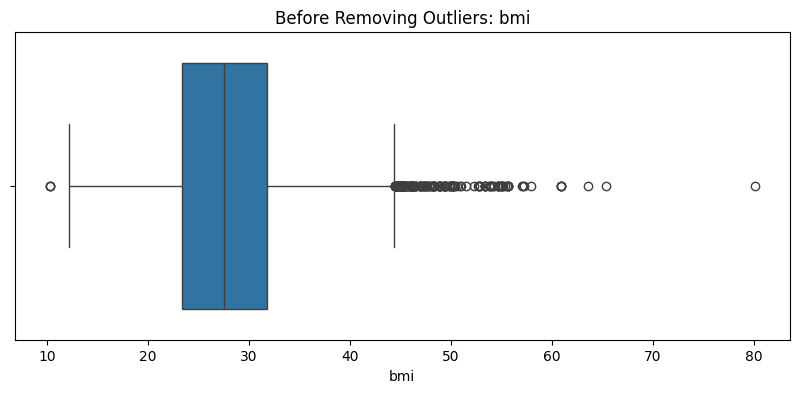

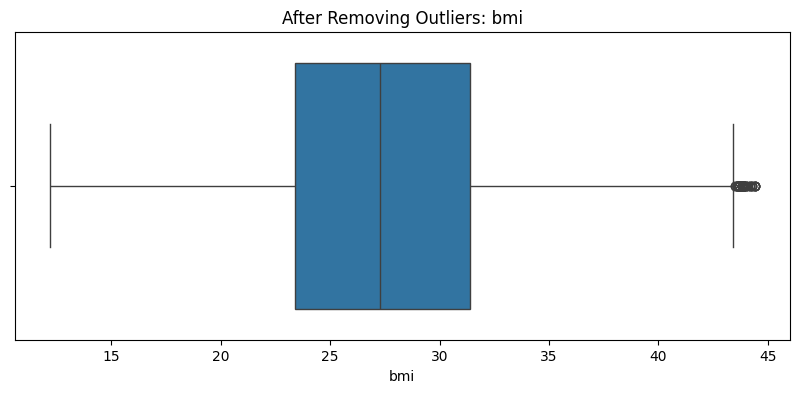

In [13]:
train = train.drop('id', axis=1)
train = train[train['gender'] != 'Other']
train_cleaned = remove_outliers_tukey(train, numerical_features)

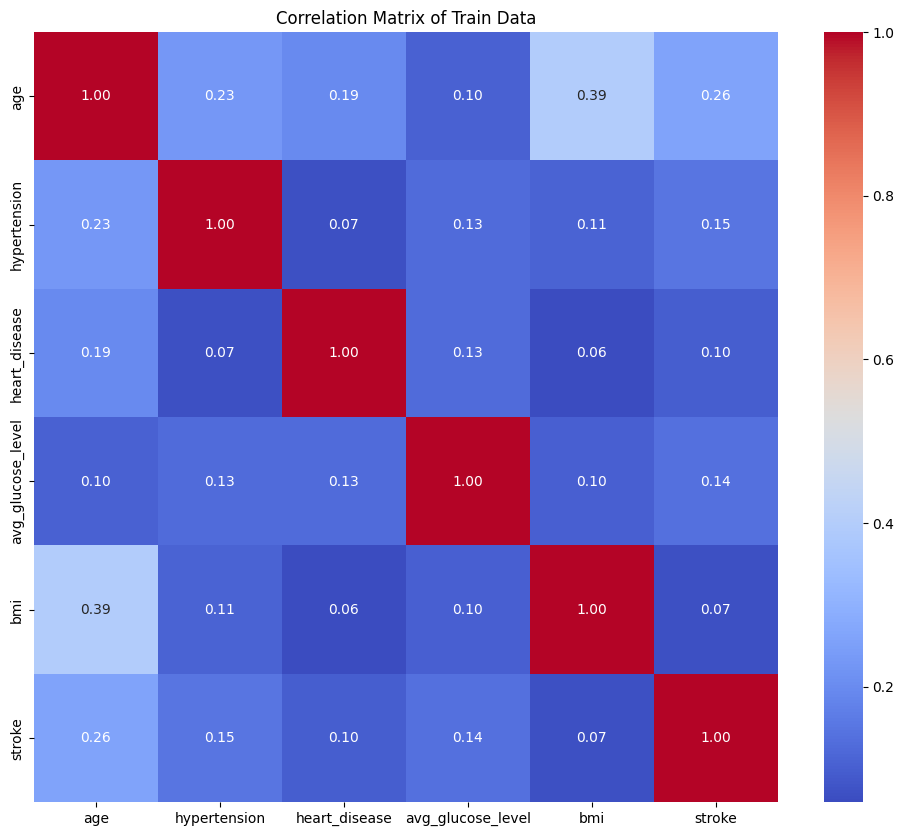

In [14]:
corr_matrix = train.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Train Data')
plt.show()

In [15]:
cat_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
train = pd.get_dummies(train, columns=cat_features, drop_first=True, dtype=int)

train['age_group'] = pd.cut(train['age'], bins=[0, 25, 45, 60, 120], labels=["Young", "Middle-aged", "Elderly", "Very Elderly"])
train = pd.get_dummies(train, columns=['age_group'], drop_first=True, dtype=int)
train['bmi_category'] = pd.cut(train['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Normal", "Overweight", "Obese"])
train = pd.get_dummies(train, columns=['bmi_category'], drop_first=True, dtype=int)
train['glucose_category'] = pd.cut(train['avg_glucose_level'], bins=[0, 70, 140, 300], labels=["Low", "Normal", "High"])
train = pd.get_dummies(train, columns=['glucose_category'], drop_first=True, dtype=int)
train = train.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
train['ever_married'] = train['ever_married'].map({'Yes': 1, 'No': 0})

In [16]:
train.head()

,hypertension,heart_disease,ever_married,stroke,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,...,smoking_status_never smoked,smoking_status_smokes,age_group_Middle-aged,age_group_Elderly,age_group_Very Elderly,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,glucose_category_Normal,glucose_category_High
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,1,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,1,0
4,0,0,1,1,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0


In [17]:
train.isnull().sum()

,0
hypertension,0
heart_disease,0
ever_married,0
stroke,0
gender_Male,0
work_type_Never_worked,0
work_type_Private,0
work_type_Self-employed,0
work_type_children,0
Residence_type_Urban,0


In [18]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.model_selection import train_test_split

# 定义采样方法
resampling_method = "SMOTE+undersampling"  # 选项: "SMOTE", "BorderlineSMOTE", "ADASYN", "undersampling", "SMOTE+undersampling"

# 准备特征矩阵和目标变量
X = train.drop(columns=['stroke']).copy()
y = train['stroke'].copy()

# 检查数据是否存在缺失值
assert X.isnull().sum().sum() == 0, "Warning: 采样前检测到 X 存在缺失值。"

# 选择采样方法
if resampling_method == "SMOTE":
    resampler = SMOTE(sampling_strategy='auto', random_state=222)
elif resampling_method == "BorderlineSMOTE":
    resampler = BorderlineSMOTE(sampling_strategy='auto', random_state=222)
elif resampling_method == "ADASYN":
    resampler = ADASYN(sampling_strategy='auto', random_state=222)
elif resampling_method == "undersampling":
    resampler = RandomUnderSampler(sampling_strategy='auto', random_state=222)
elif resampling_method == "SMOTE+undersampling":
    # 先使用 SMOTE 进行过采样
    smote = SMOTE(sampling_strategy=0.5, random_state=222)  # 过采样至 50% 比例
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # 再对多数类进行欠采样以达到均衡
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=222)
    X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)
else:
    raise ValueError("无效的采样方法，请选择 'SMOTE', 'BorderlineSMOTE', 'ADASYN', 'undersampling' 或 'SMOTE+undersampling'。")

# 若非 "SMOTE+undersampling"，则直接应用所选采样方法
if resampling_method not in ["SMOTE+undersampling"]:
    X_resampled, y_resampled = resampler.fit_resample(X, y)

# 重新索引数据
X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

# 输出采样后的类别分布
print(f"\n类别分布 ({resampling_method} 后):")
print(y_resampled.value_counts(normalize=True))

# 数据集划分 (80% 训练集, 20% 测试集)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=222, stratify=y_resampled
)

# 输出训练集中的类别分布
print("\n训练集类别分布:")
print(y_train.value_counts(normalize=True))

# 组合回采样后的训练数据集
df_train_resampled = pd.concat([pd.DataFrame(X_train, columns=X.columns),
                                pd.DataFrame(y_train, columns=['stroke'])], axis=1)

# 显示前几行数据
df_train_resampled.head()


类别分布 (SMOTE+undersampling 后):
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

训练集类别分布:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


,hypertension,heart_disease,ever_married,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,...,smoking_status_smokes,age_group_Middle-aged,age_group_Elderly,age_group_Very Elderly,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,glucose_category_Normal,glucose_category_High,stroke
4766,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1927,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1949,1,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
9949,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,1,0,1
2198,0,0,1,0,0,0,1,0,1,1,...,0,0,0,1,0,1,0,1,0,0


In [19]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 9388 entries, 4766 to 19
Series name: stroke
Non-Null Count  Dtype
--------------  -----
9388 non-null   int64
dtypes: int64(1)
memory usage: 146.7 KB



============ Logistic Regression ============
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       938
           1       0.80      0.82      0.81       939

    accuracy                           0.81      1877
   macro avg       0.81      0.81      0.81      1877
weighted avg       0.81      0.81      0.81      1877

Accuracy: 0.8055
F1 Score: 0.8088
ROC AUC: 0.8757649452418419
Confusion Matrix:
[[740 198]
 [167 772]]


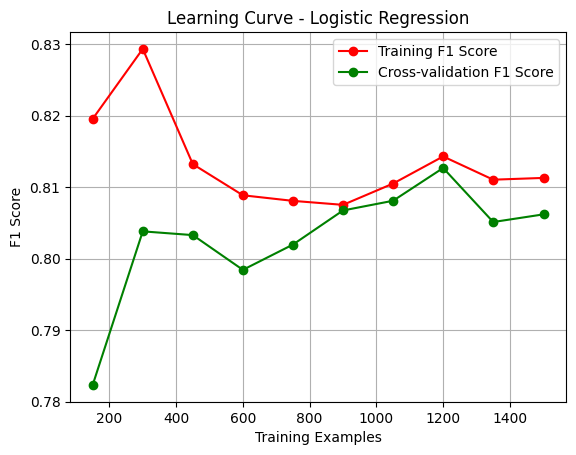


============ Decision Tree ============
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       938
           1       0.90      0.94      0.92       939

    accuracy                           0.92      1877
   macro avg       0.92      0.92      0.92      1877
weighted avg       0.92      0.92      0.92      1877

Accuracy: 0.9153
F1 Score: 0.9171
ROC AUC: 0.9777970031176841
Confusion Matrix:
[[839  99]
 [ 60 879]]


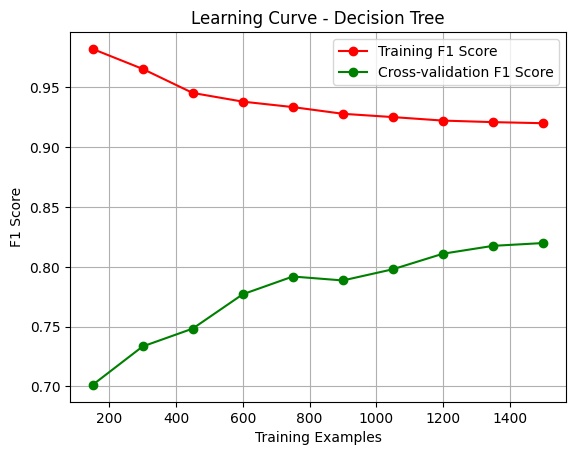


============ Random Forest ============
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       938
           1       0.89      0.95      0.92       939

    accuracy                           0.92      1877
   macro avg       0.92      0.92      0.92      1877
weighted avg       0.92      0.92      0.92      1877

Accuracy: 0.9153
F1 Score: 0.9178
ROC AUC: 0.9749256910336497
Confusion Matrix:
[[830 108]
 [ 51 888]]


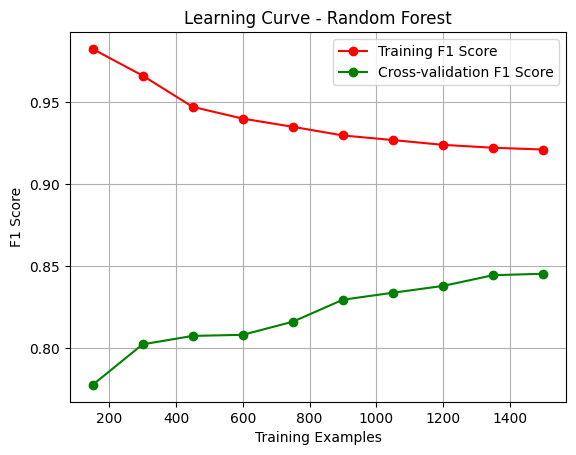


============ Gradient Boosting ============
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       938
           1       0.81      0.86      0.84       939

    accuracy                           0.83      1877
   macro avg       0.83      0.83      0.83      1877
weighted avg       0.83      0.83      0.83      1877

Accuracy: 0.8311
F1 Score: 0.8363
ROC AUC: 0.9098182070024137
Confusion Matrix:
[[750 188]
 [129 810]]


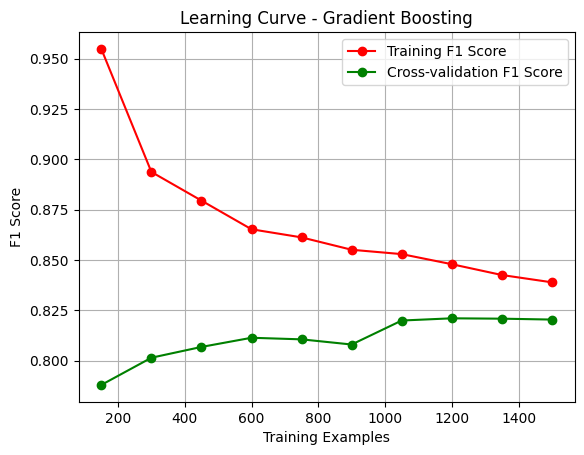


============ AdaBoost ============
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       938
           1       0.78      0.83      0.80       939

    accuracy                           0.80      1877
   macro avg       0.80      0.80      0.80      1877
weighted avg       0.80      0.80      0.80      1877

Accuracy: 0.7975
F1 Score: 0.8039
ROC AUC: 0.8671055948009837
Confusion Matrix:
[[718 220]
 [160 779]]


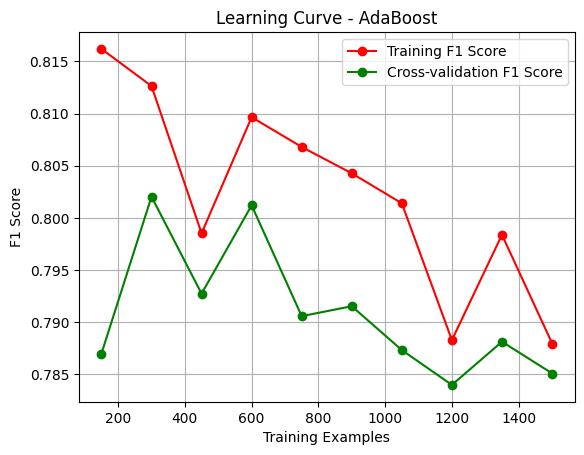


============ SVC ============
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       938
           1       0.82      0.88      0.85       939

    accuracy                           0.84      1877
   macro avg       0.85      0.84      0.84      1877
weighted avg       0.85      0.84      0.84      1877

Accuracy: 0.8428
F1 Score: 0.8491
ROC AUC: 0.9182158581805714
Confusion Matrix:
[[752 186]
 [109 830]]


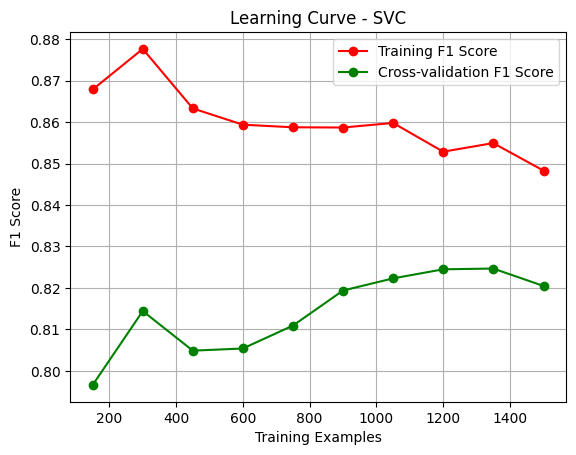


============ K-Nearest Neighbors ============
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       938
           1       0.83      0.91      0.87       939

    accuracy                           0.86      1877
   macro avg       0.87      0.86      0.86      1877
weighted avg       0.87      0.86      0.86      1877

Accuracy: 0.8647
F1 Score: 0.8708
ROC AUC: 0.9313189869911056
Confusion Matrix:
[[767 171]
 [ 83 856]]


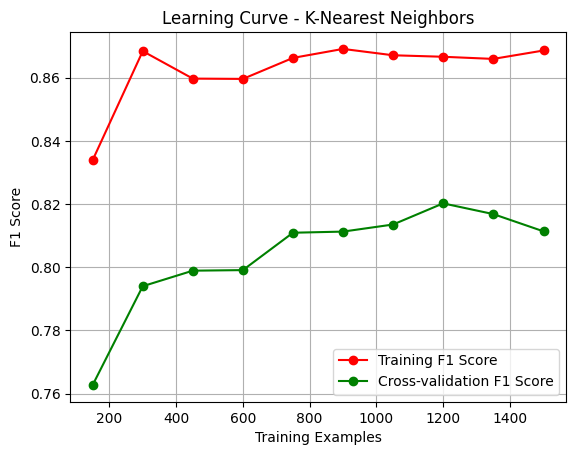


============ Gaussian Naive Bayes ============
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.44      0.61       938
           1       0.64      0.98      0.78       939

    accuracy                           0.71      1877
   macro avg       0.80      0.71      0.69      1877
weighted avg       0.80      0.71      0.69      1877

Accuracy: 0.7144
F1 Score: 0.7752
ROC AUC: 0.839901360382024
Confusion Matrix:
[[417 521]
 [ 15 924]]


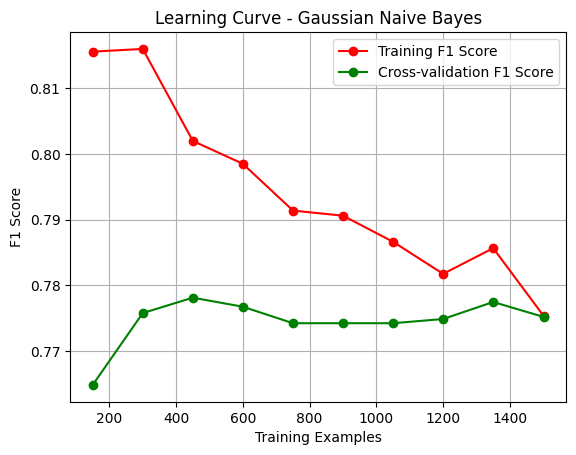


============ Bernoulli Naive Bayes ============
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       938
           1       0.80      0.78      0.79       939

    accuracy                           0.79      1877
   macro avg       0.79      0.79      0.79      1877
weighted avg       0.79      0.79      0.79      1877

Accuracy: 0.7917
F1 Score: 0.7883
ROC AUC: 0.8582180380616315
Confusion Matrix:
[[758 180]
 [211 728]]


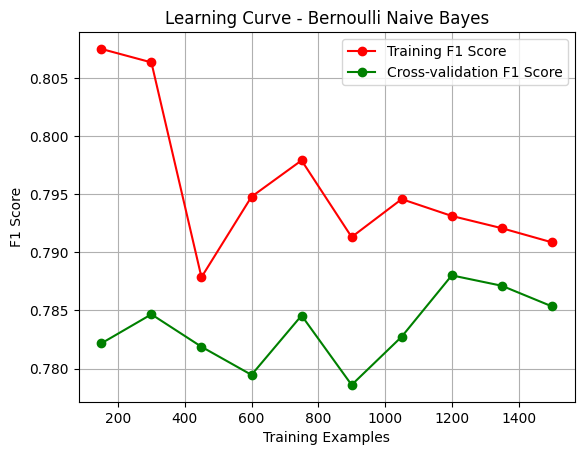


============ MLP Neural Network ============
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       938
           1       0.87      0.94      0.90       939

    accuracy                           0.90      1877
   macro avg       0.90      0.90      0.90      1877
weighted avg       0.90      0.90      0.90      1877

Accuracy: 0.9004
F1 Score: 0.9042
ROC AUC: 0.9620189785894807
Confusion Matrix:
[[807 131]
 [ 56 883]]


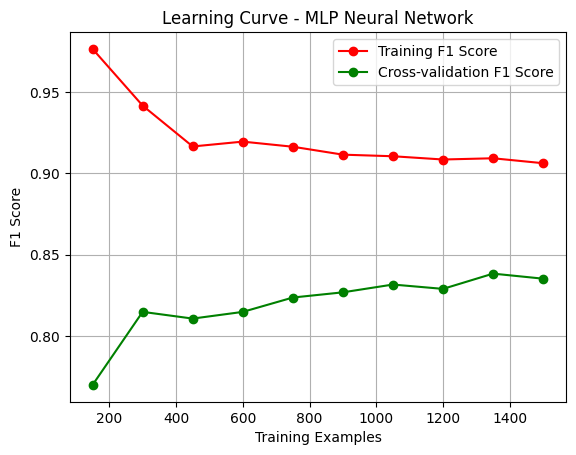


============ XGBoost ============
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       938
           1       0.87      0.94      0.91       939

    accuracy                           0.90      1877
   macro avg       0.90      0.90      0.90      1877
weighted avg       0.90      0.90      0.90      1877

Accuracy: 0.9014
F1 Score: 0.9054
ROC AUC: 0.9655397135727116
Confusion Matrix:
[[807 131]
 [ 54 885]]


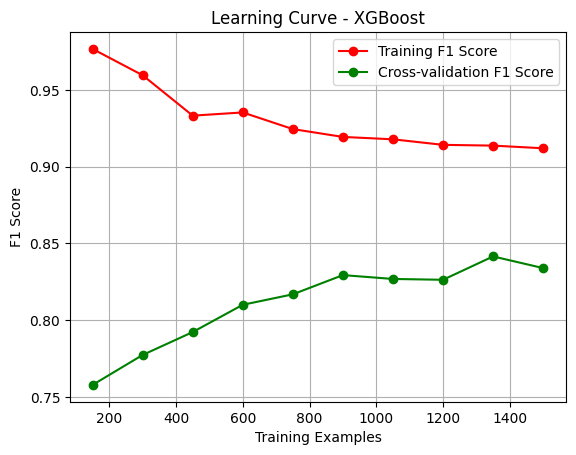


============ LightGBM ============
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 939, number of negative: 938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 1877, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500266 -> initscore=0.001066
[LightGBM] [Info] Start training from score 0.001066
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       938
           1       0.86      0.93      0.89       939

    accuracy                           0.89      1877
   macro avg       0.89      0.89      0.89      1877
weighted avg       0.89      0.89      0

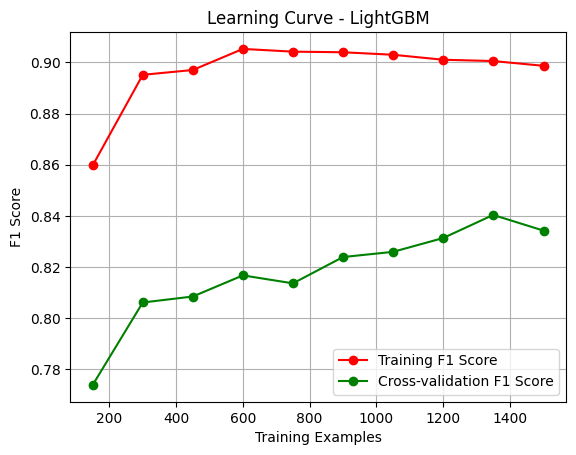

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 随机抽取 20% 的数据样本，保持类别分布（stratify）
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=0.2, random_state=222, stratify=y_train
)

# 定义多个分类模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=222),
    "Decision Tree": DecisionTreeClassifier(random_state=222),
    "Random Forest": RandomForestClassifier(random_state=222),
    "Gradient Boosting": GradientBoostingClassifier(random_state=222),
    "AdaBoost": AdaBoostClassifier(random_state=222),
    "SVC": SVC(probability=True, random_state=222),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),  # 默认 5 个邻居
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=222),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=222),
    "LightGBM": LGBMClassifier(random_state=222)
}

# 遍历每个模型，进行训练、评估和绘制学习曲线
for name, model in models.items():
    print(f"\n============ {name} ============")

    # 在抽样数据上训练模型
    model.fit(X_sample, y_sample)

    # 模型预测（这里为了示例直接在训练样本上评估，实际应用中建议用交叉验证或独立测试集）
    y_pred = model.predict(X_sample)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_sample)[:, 1]
        roc_auc = roc_auc_score(y_sample, y_proba)
    else:
        roc_auc = "N/A"

    # 输出评估指标
    print("Classification Report:")
    print(classification_report(y_sample, y_pred))
    print("Accuracy: {:.4f}".format(accuracy_score(y_sample, y_pred)))
    print("F1 Score: {:.4f}".format(f1_score(y_sample, y_pred)))
    print("ROC AUC: {}".format(roc_auc))
    print("Confusion Matrix:")
    print(confusion_matrix(y_sample, y_pred))

    # 计算学习曲线（采用 F1 作为评分指标）
    # 注意：learning_curve 无法设置 random_state，因此这里的随机性依赖于 CV 划分
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X_sample, y_sample,
        cv=5,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)

    # 绘制学习曲线
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation F1 Score")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [21]:
def plot_learning_curve(model, X, y, name, cv=5, scoring='f1', n_jobs=-1):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation F1 Score")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


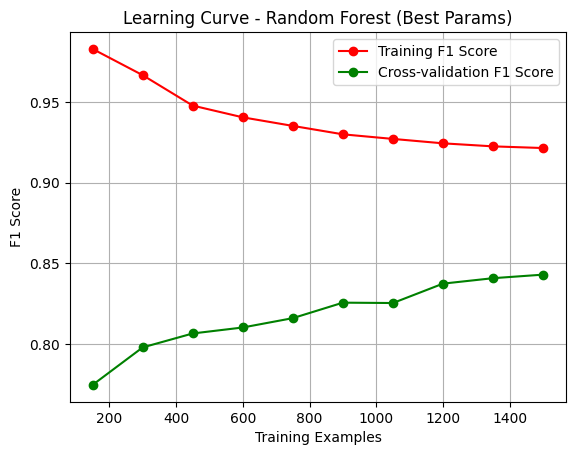

Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score:  0.8709939776161469


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定义随机森林模型的参数搜索空间
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# 创建随机森林分类器（指定随机种子保证结果可复现）
rf = RandomForestClassifier(random_state=222)

# 初始化 GridSearchCV，采用5折交叉验证，优化目标为 F1 分数
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid,
                              cv=5,
                              scoring='f1',
                              n_jobs=-1,
                              verbose=2)

# 在 SMOTE 平衡后的训练数据上进行网格搜索
grid_search_rf.fit(X_train, y_train)

# 获取最佳的随机森林模型
best_rf = grid_search_rf.best_estimator_

# 使用最佳模型绘制学习曲线
plot_learning_curve(best_rf, X_sample, y_sample, "Random Forest (Best Params)")

print("Best Parameters: ", grid_search_rf.best_params_)
print("Best F1 Score: ", grid_search_rf.best_score_)

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 定义最佳参数
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 222
}

X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=0.2, random_state=222, stratify=y_train
)

# 构建随机森林模型并拟合数据
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_sample, y_sample)

# 使用 SelectFromModel 进行特征选择，阈值设为中位数
selector = SelectFromModel(rf_best, threshold='median', prefit=True)
X_selected = selector.transform(X_sample)

# 获取被选择特征的名称
selected_features = X_sample.columns[selector.get_support()]

print("Selected Features:")
print(selected_features)
print("Original feature shape:", X_sample.shape)
print("Selected feature shape:", X_selected.shape)

Selected Features:
Index(['hypertension', 'ever_married', 'gender_Male', 'work_type_Private',
       'Residence_type_Urban', 'smoking_status_never smoked',
       'age_group_Middle-aged', 'age_group_Elderly', 'age_group_Very Elderly',
       'glucose_category_Normal'],
      dtype='object')
Original feature shape: (1877, 20)
Selected feature shape: (1877, 10)


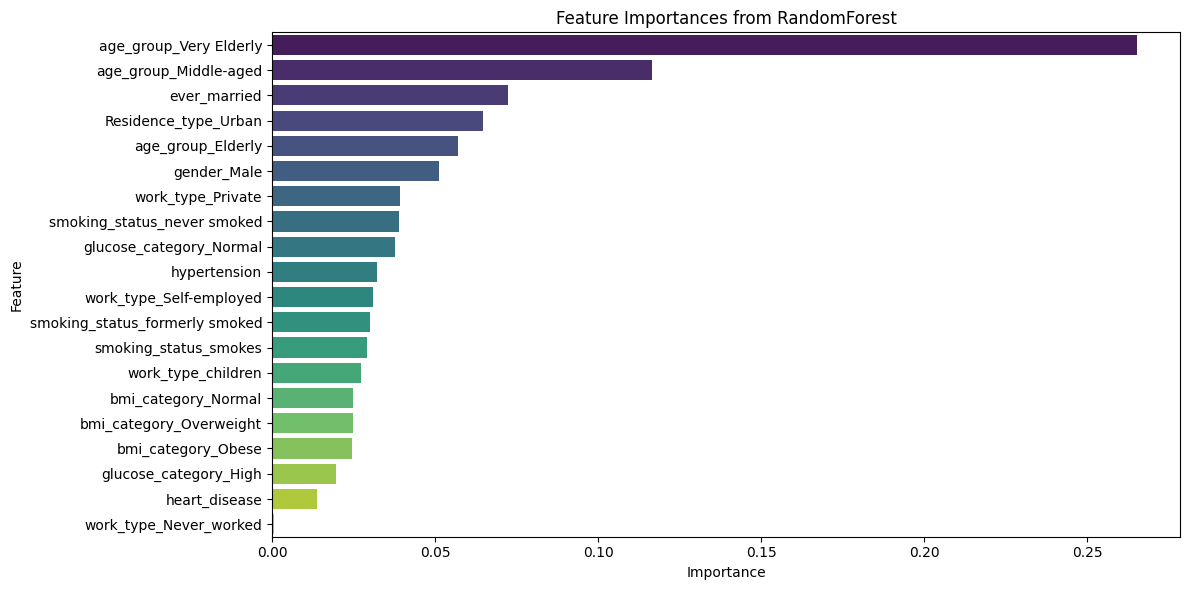

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 rf_best 是之前用最佳参数拟合好的随机森林模型，X_sample 是特征数据
# 提取特征重要性
importances = rf_best.feature_importances_
features = X_sample.columns

# 构建 DataFrame 用于可视化
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 绘制条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette="viridis")
plt.title('Feature Importances from RandomForest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Feature Importances (sorted):
                           feature  importance
14          age_group_Very Elderly    0.265167
12           age_group_Middle-aged    0.116509
2                     ever_married    0.072310
8             Residence_type_Urban    0.064642
13               age_group_Elderly    0.056890
3                      gender_Male    0.051151
5                work_type_Private    0.039214
10     smoking_status_never smoked    0.039076
18         glucose_category_Normal    0.037613
0                     hypertension    0.032093
6          work_type_Self-employed    0.031079
9   smoking_status_formerly smoked    0.030086
11           smoking_status_smokes    0.029059
7               work_type_children    0.027189
15             bmi_category_Normal    0.024762
16         bmi_category_Overweight    0.024744
17              bmi_category_Obese    0.024483
19           glucose_category_High    0.019748
1                    heart_disease    0.013706
4           work_type_Never_wo

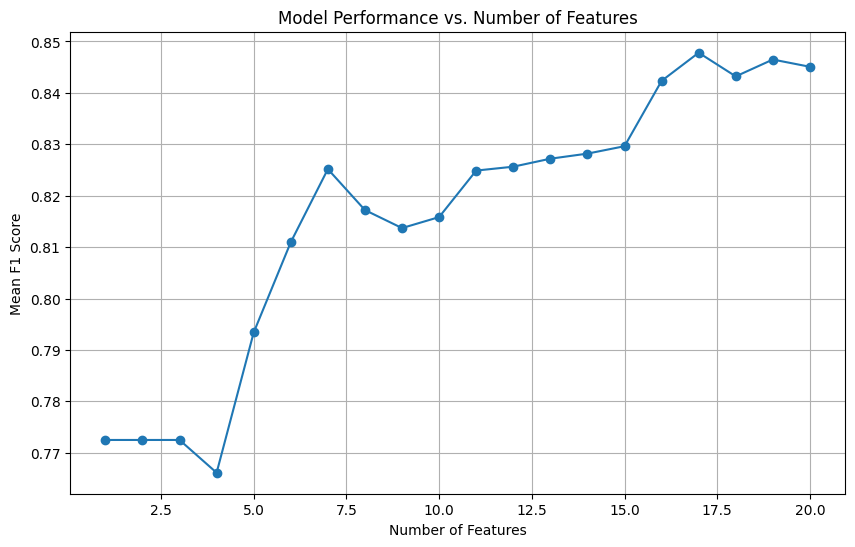

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 获取各特征的重要性，并按照降序排序
importances = rf_best.feature_importances_
features = X_sample.columns
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 打印各特征的重要性排序
print("Feature Importances (sorted):")
print(feature_importance_df)

# 将排序后的特征名称存入列表
sorted_features = feature_importance_df['feature'].tolist()

# 定义存储不同特征数量下模型表现的列表
feature_counts = []
f1_scores = []

# 测试使用前 k 个特征时模型的表现，k 从 1 到全部特征
for k in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:k]
    X_subset = X_sample[selected_features]

    # 使用最佳参数构造模型
    model = RandomForestClassifier(**best_params)

    # 5折交叉验证，计算 F1 得分
    scores = cross_val_score(model, X_subset, y_sample, cv=5, scoring='f1', n_jobs=-1)
    mean_score = np.mean(scores)

    feature_counts.append(k)
    f1_scores.append(mean_score)

    print(f"Using top {k} features: Mean F1 Score = {mean_score:.4f}")

# 绘制不同特征数量下模型的 F1 表现
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, f1_scores, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('Mean F1 Score')
plt.title('Model Performance vs. Number of Features')
plt.grid(True)
plt.show()

Top 17 features selected:
['age_group_Very Elderly', 'age_group_Middle-aged', 'ever_married', 'age_group_Elderly', 'Residence_type_Urban', 'gender_Male', 'work_type_Private', 'work_type_children', 'glucose_category_Normal', 'smoking_status_never smoked', 'work_type_Self-employed', 'smoking_status_formerly smoked', 'hypertension', 'bmi_category_Obese', 'smoking_status_smokes', 'bmi_category_Normal', 'bmi_category_Overweight']

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1174
           1       0.82      0.94      0.87      1174

    accuracy                           0.86      2348
   macro avg       0.87      0.86      0.86      2348
weighted avg       0.87      0.86      0.86      2348

Accuracy: 0.8650
F1 Score: 0.8742
ROC AUC: 0.9192
Confusion Matrix:
[[ 930  244]
 [  73 1101]]


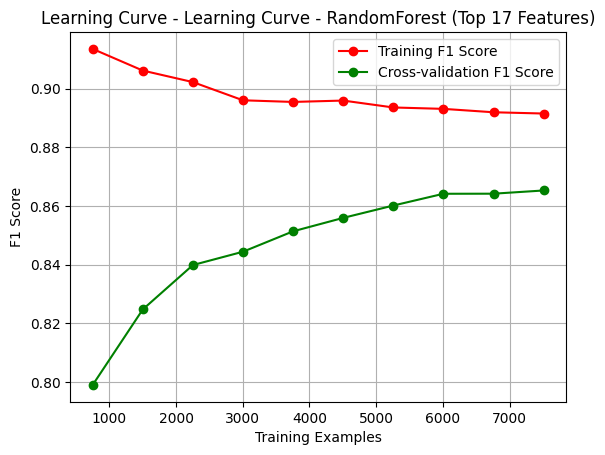

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

# 定义最佳参数（包含随机种子）
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 222
}

# ================================
# 第一步：利用最佳参数训练模型，并提取特征重要性
# ================================
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# 获取特征重要性
importances = rf_model.feature_importances_
features = X_train.columns

# 构建 DataFrame，按重要性降序排序
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 选择排名前17的特征
top_features = importance_df['feature'].head(17).tolist()
print("Top 17 features selected:")
print(top_features)

# ================================
# 第二步：构建基于选定特征的训练集和测试集
# ================================
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# ================================
# 第三步：在训练集上训练模型，在测试集上进行预测并输出评分
# ================================
rf_top = RandomForestClassifier(**best_params)
rf_top.fit(X_train_top, y_train)

# 预测测试集
y_pred = rf_top.predict(X_test_top)

# 输出各项评分
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
if hasattr(rf_top, "predict_proba"):
    y_proba = rf_top.predict_proba(X_test_top)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 使用最终模型在选定特征的训练集上绘制学习曲线
plot_learning_curve(rf_top, X_train_top, y_train, "Learning Curve - RandomForest (Top 17 Features)")


Permutation Feature Importance (Voting Classifier):
                           Feature  Importance
0           age_group_Very Elderly    0.143332
4             Residence_type_Urban    0.059578
8          glucose_category_Normal    0.057849
1            age_group_Middle-aged    0.056393
5                      gender_Male    0.056114
6                work_type_Private    0.054957
3                age_group_Elderly    0.048353
15             bmi_category_Normal    0.046313
2                     ever_married    0.039438
9      smoking_status_never smoked    0.038289
11  smoking_status_formerly smoked    0.037717
10         work_type_Self-employed    0.035484
16         bmi_category_Overweight    0.034673
13              bmi_category_Obese    0.034489
14           smoking_status_smokes    0.022403
12                    hypertension    0.020014
7               work_type_children    0.010046


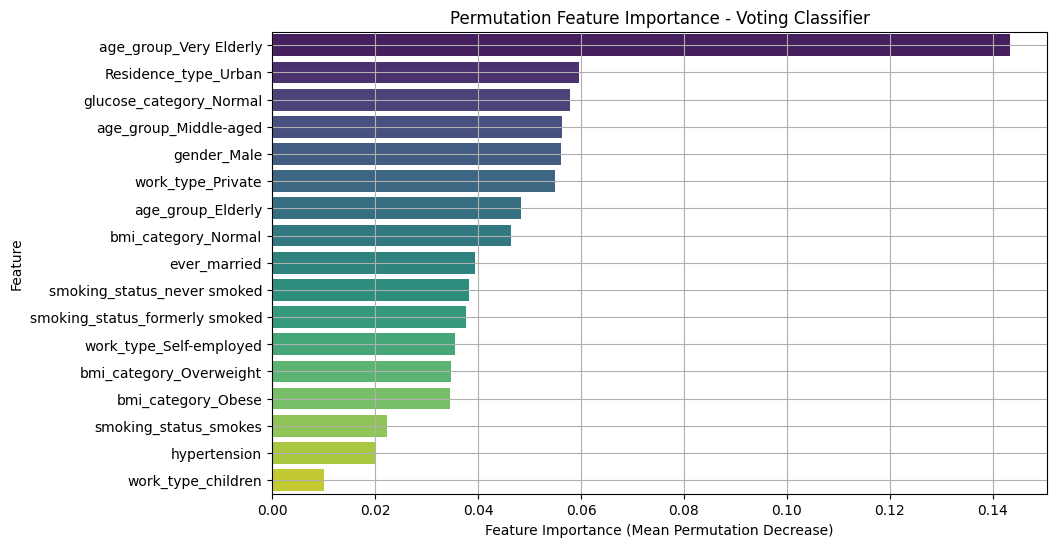

In [27]:
from sklearn.inspection import permutation_importance

# 计算特征重要性（基于测试集）
perm_importance = permutation_importance(rf_top, X_test_top, y_test, scoring='f1', n_repeats=10, random_state=222, n_jobs=-1)

# 将特征重要性转换为 DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_test_top.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# 输出最重要的特征
print("\nPermutation Feature Importance (Voting Classifier):")
print(feature_importance_df)

# 可视化 Permutation Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance (Mean Permutation Decrease)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance - Voting Classifier")
plt.grid(True)
plt.show()

In [ ]:
#pip install lime

In [29]:
import lime
import lime.lime_tabular
import numpy as np

# 初始化 LIME 解释器
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_top),
    feature_names=X_train_top.columns.tolist(),
    class_names=["No Stroke", "Stroke"],
    mode="classification"
)

# 选取一个测试样本进行 LIME 解释
sample_index = 0
sample = X_test_top.iloc[sample_index]

# 生成 LIME 解释
exp = explainer.explain_instance(sample, rf_top.predict_proba)

# 显示 LIME 解释
exp.show_in_notebook()

In [ ]:
#pip install fairlearn

In [31]:
import numpy as np
import pandas as pd
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 选择敏感特征（年龄相关）
sensitive_feature = X_test_top[["age_group_Middle-aged", "age_group_Elderly", "age_group_Very Elderly"]]

# 获取 Random Forest 预测结果
y_pred_rf = rf_top.predict(X_test_top)

# 计算公平性指标
dp_diff_rf = demographic_parity_difference(y_test, y_pred_rf, sensitive_features=sensitive_feature)
eo_diff_rf = equalized_odds_difference(y_test, y_pred_rf, sensitive_features=sensitive_feature)

# 输出公平性分析结果
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eo_diff_rf:.4f}")

# 计算其他模型评估指标
print("\nOriginal RandomForest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf_top.predict_proba(X_test_top)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Demographic Parity Difference: 0.9154
Equalized Odds Difference: 0.7470

Original RandomForest Performance:
Accuracy: 0.8649914821124361
F1 Score: 0.8741564112743152
ROC AUC: 0.9192462177386822
Confusion Matrix:
 [[ 930  244]
 [  73 1101]]


In [32]:
"""""
	1.	Demographic Parity Difference（DPD）：
	•	值接近 0：不同年龄组的预测结果比例相似，表示公平。
	•	值偏离 0：说明某些年龄组可能受到了偏见。
	2.	Equalized Odds Difference（EOD）：
	•	值接近 0：表示不同年龄组的 误判率 和 召回率 一致。
	•	值偏离 0：说明某些年龄组的预测结果更容易被误判。
"""""
from fairlearn.reductions import GridSearch, DemographicParity

# 重新训练 Random Forest，加入公平性优化
fair_rf_model = GridSearch(
    estimator=rf_top,
    constraints=DemographicParity(),  # 约束优化
    grid_size=10  # 训练 10 组不同公平性权衡的模型
)

# 训练公平性优化后的模型（用敏感变量约束）
fair_rf_model.fit(X_train_top, y_train, sensitive_features=X_train_top[["age_group_Middle-aged", "age_group_Elderly", "age_group_Very Elderly"]])

# 预测新模型结果
y_pred_fair_rf = fair_rf_model.predict(X_test_top)

# 计算优化后模型的公平性指标
dp_diff_fair_rf = demographic_parity_difference(y_test, y_pred_fair_rf, sensitive_features=sensitive_feature)
eo_diff_fair_rf = equalized_odds_difference(y_test, y_pred_fair_rf, sensitive_features=sensitive_feature)

# 计算优化后模型的 Accuracy, F1-score
acc_fair_rf = accuracy_score(y_test, y_pred_fair_rf)
f1_fair_rf = f1_score(y_test, y_pred_fair_rf)
roc_auc_fair_rf = roc_auc_score(y_test, fair_rf_model.predict_proba(X_test_top)[:, 1])

# 输出优化后公平性分析
print("\nAfter Fairness Optimization (RandomForest):")
print(f"Demographic Parity Difference: {dp_diff_fair_rf:.4f}")
print(f"Equalized Odds Difference: {eo_diff_fair_rf:.4f}")
print("Optimized Model Performance:")
print(f"Accuracy: {acc_fair_rf:.4f}")
print(f"F1 Score: {f1_fair_rf:.4f}")
print(f"ROC AUC: {roc_auc_fair_rf:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_fair_rf))


After Fairness Optimization (RandomForest):
Demographic Parity Difference: 1.0000
Equalized Odds Difference: 1.0000
Optimized Model Performance:
Accuracy: 0.6733
F1 Score: 0.6998
ROC AUC: 0.6101
Confusion Matrix:
 [[687 487]
 [280 894]]


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索范围
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 进行 Grid Search 超参数调优
rf = RandomForestClassifier(random_state=222)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_top, y_train)

# 获取最佳模型
best_rf = grid_search.best_estimator_

# 训练最佳 Random Forest
best_rf.fit(X_train_top, y_train)

# 预测结果
y_pred_best_rf = best_rf.predict(X_test_top)

# 计算模型表现
print("\nBest RandomForest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("F1 Score:", f1_score(y_test, y_pred_best_rf))
print("ROC AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test_top)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))


Best RandomForest Performance:
Accuracy: 0.8624361158432708
F1 Score: 0.8707482993197279
ROC AUC: 0.920887761232148
Confusion Matrix:
 [[ 937  237]
 [  86 1088]]


In [34]:
import numpy as np
from sklearn.utils import resample

# 获取预测概率
y_proba_rf = best_rf.predict_proba(X_test_top)[:, 1]

# 设定 bootstrap 采样次数
n_bootstraps = 1000
bootstrap_scores = []

# 进行 bootstrap 采样
for _ in range(n_bootstraps):
    indices = resample(range(len(y_proba_rf)), replace=True)  # 生成随机索引
    bootstrap_scores.append(roc_auc_score(y_test.iloc[indices], y_proba_rf[indices]))

# 计算 95% 置信区间
ci_lower, ci_upper = np.percentile(bootstrap_scores, [2.5, 97.5])

# 输出置信区间
print(f"95% Confidence Interval for ROC AUC: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval for ROC AUC: (0.9090, 0.9324)
